# Object Detection using YOLO

Welcome to this week's hands-on lab. In this lab, we are going to learn how to train a balloon detector!

At the end of this exercise, you will be able to:

- create an object detection dataset in YOLO format
- fine-tune a YOLOv8 pretrained model with the custom dataset
- monitor the training progress and evaluation metrics
- deploy the trained model for object detection

## Create an object detection dataset

We will use a sample balloon dataset to illustrate the process of annotation and packaging the dataset into different format for object detection (e.g. YOLO, Pascal VOC, COCO, etc).

To annotate, there are many different tools available, such as the very basic [LabelImg](https://github.com/HumanSignal/labelImg) , or the more feature-packed tool such as [Label Studio](https://labelstud.io/), or online service such as [Roboflow](https://roboflow.com/).

### Raw Image Dataset

You can download the balloon images (without annotations) from this link:

https://github.com/nyp-sit/iti107-2024S2/raw/refs/heads/main/data/balloon_raw_dataset.zip

Unzip the file to a local folder.

There are total of 74 images. You should divide the images into both training and validation set (e.g. 80%-20%, i.e. 59 images for train, and 15 for test).


### Option 1: Label Studio

You can follow the [steps](https://labelstud.io/guide/quick_start) here to setup Label Studio on your PC. It is recommended to setup a conda environment before you install the Label Studio.  

Here are the steps that need to be done:
1. Create a new Project
2. Import the images into Label Studio
3. Set up the Labelling UI tempalte (choose Object Detection with Bounding Box template)
4. Export the dataset in YOLO format.

The exported dataset will have the following folder structure:
```
<root folder>
classes.txt    --> contains the labels, with each class label on a new line
--images --> contains the images
--labels --> contains the annotations (i.e. bbox coordinates)
notes.json --> some info about this dataset (i.e. not used)
```

For training with YOLOv8 (from Ultralytics), you need to organize the files into `train` and `validate` (and optionally `test`) folders, and to create a `data.yaml` file to provide information about the folder location of test and validation set:

```
<root folder>
--train
----images
----labels
--valid
----images
----labels
data.yaml
```

The data.yaml file should specify the following:
```
train: ../train/images
val: ../valid/images
test: ../test/images

names:
    0: balloon
```

If you have more than one class of object to detect, specify the rest of the names under the names field.


## Option 2: Roboflow

Alternatively, you can use the online service Roboflow to do annotation. Roboflow integrates very well with Ultralytics and you can easily export the dataset in a format recognized by Ultralytics trainer (for YOLO model)

You can create a new account with [Roboflow](https://roboflow.com/).

Similarly, you can create a new project, upload all the raw images, annotate them and then export.

You can choose the format to be YOLOv8 and choose local directory to download the dataset locally instead of pushing it to the Roboflow universal wish.

Here is a [introductory blog](https://blog.roboflow.com/getting-started-with-roboflow/) on using the Roboflow to annotate.





## Auto Labelling using Grounding DINO

Both Label Studio and Roboflow supports the use of Grounding DINO to auto label the dataset.

[Grounding DINO](https://github.com/IDEA-Research/GroundingDINO) is open-set object detector, marrying Transformer-based detector DINO with grounded pre-training, which can detect arbitrary objects with human inputs (prompts) such as category names or referring expressions.

### Using Grounding DINO with Label Studio

You can follow the instruction [here](https://labelstud.io/blog/using-text-prompts-for-image-annotation-with-grounding-dino-and-label-studio/)  to setup the Grounding DINO ML backend to integrate with your label studio.

### Using Grounding DINO with Roboflow

Here is a [video tutorial](https://youtu.be/SDV6Gz0suAk) on using Grounding DINO with Roboflow.


### Download Annotated Dataset

To save you time for this lab, you can download a pre-annotated balloon dataset [here](https://github.com/nyp-sit/iti107-2024S2/raw/refs/heads/main/data/balloon_annotated_dataset.zip).

We download and unzip to the directory called `datasets`



In [ ]:
%%capture
%%bash
wget https://github.com/chugmn/NYP107Assign/raw/refs/heads/main/penorwatches.v2i.yolov8.zip
mkdir -p datasets
unzip penorwatches.v2i.yolov8.zip -d datasets/

In [ ]:
%%capture
!pip install ultralytics
!pip install comet_ml

## Training the Model

YOLOv8 comes with different sizes of pretrained models: yolov8n, yolov8s, .... They differs in terms of their sizes, inference speeds and mean average precision:

<img src="https://github.com/nyp-sit/iti107-2024S2/blob/main/assets/yolo-models.png?raw=true" width="70%"/>


We will use the small pretrained model yolo8s and finetune it on our custom dataset.


### Setup the logging

Ultralytics support logging to `wandb`, `comet.ml` and `tensorboard`, out of the box. Here we only enable wandb.

You need to create an account at [`wandb`](https://wandb.ai) and get the API key from https://wandb.ai/authorize.


In [ ]:
from ultralytics import settings

settings.update({"wandb": True,
                 "comet": False,
                 "tensorboard": False})

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


### Training

We specify the path to `data.yaml` file, and train with a batch size of 15, and we also save the checkpoint at each epoch (save_period=1). We assume here you are connected to a GPU, hence we can specify the device to use as `device=0` to select the first GPU.  We specify the project name as `balloon`, this will create a folder called `balloon` to store the weights and various training artifacts such as F1, PR curves, confusion matrics, training results (loss, mAP, etc).

For a complete listing of train settings, you can see [here](https://docs.ultralytics.com/modes/train/#train-settings).

You can also specify the type of data [augmentation](https://docs.ultralytics.com/modes/train/#augmentation-settings-and-hyperparameters)  you want as part of the train pipeline.

You can monitor your training progress at wandb (the link is given in the train output below)


In [ ]:
!ls -la datasets/valid/images | wc -l

12


In [ ]:
from ultralytics import YOLO
from ultralytics import settings

model = YOLO("yolov8s.pt")  # Load a pre-trained YOLO model
result = model.train(data="datasets/data.yaml",
                     epochs=30,
                     save_period=1,
                     batch=16,
                     device="cpu",
                     project='pensandwatches',
                     plots=True)

Ultralytics 8.3.53 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=datasets/data.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=1, cache=False, device=cpu, workers=8, project=pensandwatches, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=T

wandb: Currently logged in as: mohan-chugani (mohan-chugani-nanyang-polytechnic). Use `wandb login --relogin` to force relogin


Freezing layer 'model.22.dfl.conv.weight'


train: Scanning /content/datasets/train/labels.cache... 29 images, 0 backgrounds, 0 corrupt: 100%|██████████| 29/29 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 2, len(boxes) = 45. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/datasets/valid/labels.cache... 9 images, 0 backgrounds, 0 corrupt: 100%|██████████| 9/9 [00:00<?, ?it/s]

Plotting labels to pensandwatches/train2/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to pensandwatches/train2
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20         0G       1.86      4.679      2.106         31        640: 100%|██████████| 2/2 [01:18<00:00, 39.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.69s/it]

                   all          9         15      0.345     0.0714     0.0817     0.0429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20         0G      1.557      3.399      1.772         44        640: 100%|██████████| 2/2 [01:14<00:00, 37.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.21s/it]

                   all          9         15      0.305     0.0714        0.1     0.0522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20         0G      1.406      2.786      1.773         32        640: 100%|██████████| 2/2 [01:13<00:00, 36.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.31s/it]

                   all          9         15       0.96     0.0714      0.109     0.0959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20         0G      1.174      2.124      1.549         48        640: 100%|██████████| 2/2 [01:13<00:00, 36.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.30s/it]

                   all          9         15      0.332      0.142      0.221      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20         0G      1.346       2.18      1.691         32        640: 100%|██████████| 2/2 [01:12<00:00, 36.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.68s/it]

                   all          9         15      0.567      0.205      0.234      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20         0G      1.198      1.947      1.565         41        640: 100%|██████████| 2/2 [01:12<00:00, 36.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<00:00,  7.96s/it]

                   all          9         15      0.493      0.268      0.252      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20         0G      1.059      1.541      1.414         56        640: 100%|██████████| 2/2 [01:11<00:00, 35.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<00:00,  7.81s/it]

                   all          9         15      0.547       0.33      0.365      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20         0G     0.9231      1.586      1.353         43        640: 100%|██████████| 2/2 [01:12<00:00, 36.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.36s/it]

                   all          9         15      0.403      0.368      0.311      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20         0G      1.057       1.76      1.438         43        640: 100%|██████████| 2/2 [01:14<00:00, 37.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.28s/it]

                   all          9         15      0.421      0.221      0.247      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20         0G      1.115       1.51      1.482         43        640: 100%|██████████| 2/2 [01:10<00:00, 35.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<00:00,  7.21s/it]

                   all          9         15      0.582      0.204      0.237      0.194


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20         0G      1.056      1.716      1.619         21        640: 100%|██████████| 2/2 [01:11<00:00, 35.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  7.00s/it]

                   all          9         15      0.667       0.27      0.265        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20         0G     0.9638      1.654       1.41         19        640: 100%|██████████| 2/2 [01:13<00:00, 36.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.18s/it]

                   all          9         15      0.777       0.33      0.352      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20         0G     0.8804      1.576      1.485         19        640: 100%|██████████| 2/2 [01:08<00:00, 34.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<00:00,  7.11s/it]

                   all          9         15      0.536      0.464      0.449      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20         0G      0.829      1.393      1.324         18        640: 100%|██████████| 2/2 [01:09<00:00, 34.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.23s/it]

                   all          9         15      0.699      0.464      0.482      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20         0G     0.9201      1.458      1.379         19        640: 100%|██████████| 2/2 [01:10<00:00, 35.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.19s/it]

                   all          9         15      0.628      0.464      0.466      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20         0G     0.8316      1.443      1.324         19        640: 100%|██████████| 2/2 [01:11<00:00, 35.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<00:00,  7.68s/it]

                   all          9         15      0.559      0.425      0.395      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20         0G     0.8003      1.283      1.296         21        640: 100%|██████████| 2/2 [01:15<00:00, 37.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<00:00,  7.16s/it]

                   all          9         15      0.751      0.411       0.42      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20         0G     0.7716      1.238      1.297         20        640: 100%|██████████| 2/2 [01:12<00:00, 36.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.19s/it]

                   all          9         15      0.798      0.411      0.455      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20         0G     0.7595      1.288      1.312         19        640: 100%|██████████| 2/2 [01:10<00:00, 35.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.60s/it]

                   all          9         15       0.61       0.47      0.536      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20         0G     0.8999      1.274       1.41         22        640: 100%|██████████| 2/2 [01:12<00:00, 36.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.05s/it]

                   all          9         15      0.629      0.545      0.606        0.4



20 epochs completed in 0.449 hours.
Optimizer stripped from pensandwatches/train2/weights/last.pt, 22.5MB
Optimizer stripped from pensandwatches/train2/weights/best.pt, 22.5MB

Validating pensandwatches/train2/weights/best.pt...
Ultralytics 8.3.53 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.07s/it]


                   all          9         15      0.628      0.545      0.606        0.4
                   pen          7          7      0.708      0.714      0.679      0.421
                 watch          8          8      0.548      0.375      0.532      0.378
Speed: 2.4ms preprocess, 659.3ms inference, 0.0ms loss, 5.2ms postprocess per image
Results saved to pensandwatches/train2


lr/pg0,▁▂▄▅▆▆▇▇█████▇▇▆▅▄▃▂
lr/pg1,▁▂▄▅▆▆▇▇█████▇▇▆▅▄▃▂
lr/pg2,▁▂▄▅▆▆▇▇█████▇▇▆▅▄▃▂
metrics/mAP50(B),▁▁▁▃▃▃▅▄▃▃▃▅▆▆▆▅▆▆▇█
metrics/mAP50-95(B),▁▁▂▃▄▄▅▄▄▄▄▅▆▆▆▆▆▆▇█
metrics/precision(B),▁▁█▁▄▃▄▂▂▄▅▆▃▅▄▄▆▆▄▄
metrics/recall(B),▁▁▁▂▃▄▅▅▃▃▄▅▇▇▇▆▆▆▇█
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▆▅▄▅▄▃▂▃▃▃▂▂▁▂▁▁▁▁▂


You can see the various graphs in your wandb dashboard, for example:

*metrics*

<img src="https://github.com/nyp-sit/iti107-2024S2/blob/main/assets/wandb-metrics.png?raw=true"/>

*Train and validation loss*

<img src="https://github.com/nyp-sit/iti107-2024S2/blob/main/assets/wandb-loss.png?raw=true"/>

You can go to the folder `balloon-->train-->weights` and you will files like epoch0.pt, epoch1.pt, .... and also best.pt.
The epoch0.pt, epoch1.pt are the checkpoints that are saved every period (in our case, we specify period as 1 epoch).  The best.pt contains the best checkpoint.

We can run the best model (using the best checkpoint) against the validation dataset to see the overall model performance on validation set.  

You should see around `0.88` for `mAP50`, and `0.78` for `mAP50-95`.

In [ ]:
from ultralytics import YOLO

model = YOLO("pensandwatches/train/weights/best.pt")
validation_results = model.val(data="datasets/data.yaml", device="cpu")

Ultralytics 8.3.54 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.00GHz)
Model summary (fused): 168 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning /content/datasets/valid/labels.cache... 9 images, 0 backgrounds, 0 corrupt: 100%|██████████| 9/9 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.96s/it]


                   all          9         15      0.777      0.394      0.536       0.32
                   pen          7          7          1      0.413      0.604       0.36
                 watch          8          8      0.553      0.375      0.467       0.28
Speed: 2.5ms preprocess, 429.0ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/detect/val3


## Export and Deployment

Your model is in pytorch format (.pt). You can export the model to various format, e.g. TorchScript, ONNX, OpenVINO, TensorRT, etc. depending on your use case, and deployment platform (e.g. CPU or GPU, etc)

You can see the list of [supported formats](https://docs.ultralytics.com/modes/export/#export-formats)  and the option they support in terms of further optimization (such as imagesize, int8, half-precision, etc) in the ultralytics site.

Ultralytics provide a utility function to benchmark your model using different supported formats automatically. You can uncomment the code in the following code cell to see the benchmark result. If you are benchmarking for CPU only, the change the `device=0` to `device='cpu'`.  

**Beware: it will take quite a while to complete the benchmark**

In [ ]:
# from ultralytics.utils.benchmarks import benchmark

# # Benchmark on GPU (device=0 means the 1st GPU device)
# benchmark(model="balloon/train/weights/best.pt", data="datasets/data.yaml", imgsz=640, half=False, device=0)


In the following code, we export it as OpenVINO. OpenVINO is optimized for inference on Intel CPUs and since we will use the model later on to do inference on local Windows machine (which runs Intel chip), we will export it as OpenVINO format. We also specify using int8 quantization, which results in faster inference, at the cost of accuracy.

For more information on OpenVINO, go to the [official documentation](https://docs.openvino.ai/2024/index.html).

After export, you can find the openvino model in `balloon\train\weights\best_openvino_model` directory.

In [ ]:
model = YOLO("pensandwatches/train/weights/best.pt")
exported_path = model.export(format="openvino", int8=True)

Ultralytics 8.3.54 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.00GHz)
WARNING ⚠️ INT8 export requires a missing 'data' arg for calibration. Using default 'data=coco8.yaml'.
Model summary (fused): 168 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs

PyTorch: starting from 'pensandwatches/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 6, 8400) (21.5 MB)

OpenVINO: starting export with openvino 2024.6.0-17404-4c0f47d2335-releases/2024/6...


No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


OpenVINO: collecting INT8 calibration images from 'data=coco8.yaml'


Scanning /content/datasets/coco8/labels/val.cache... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<?, ?it/s]


OpenVINO: WARNING ⚠️ >300 images recommended for INT8 calibration, found 4 images.
INFO:nncf:16 ignored nodes were found by patterns in the NNCFGraph
INFO:nncf:1 ignored nodes were found by types in the NNCFGraph
INFO:nncf:Not adding activation input quantizer for operation: 161 __module.model.22.dfl/aten::view/Reshape
INFO:nncf:Not adding activation input quantizer for operation: 162 __module.model.22/aten::sigmoid/Sigmoid
INFO:nncf:Not adding activation input quantizer for operation: 172 __module.model.22.dfl/aten::transpose/Transpose
INFO:nncf:Not adding activation input quantizer for operation: 181 __module.model.22.dfl/aten::softmax/Softmax
INFO:nncf:Not adding activation input quantizer for operation: 190 __module.model.22.dfl.conv/aten::_convolution/Convolution
INFO:nncf:Not adding activation input quantizer for operation: 197 __module.model.22.dfl/aten::view/Reshape_1
INFO:nncf:Not adding activation input quantizer for operation: 209 __module.model.22/aten::sub/Subtract
INFO:nn

Output()

Output()

OpenVINO: export success ✅ 22.2s, saved as 'pensandwatches/train/weights/best_int8_openvino_model/' (11.2 MB)

Export complete (23.4s)
Results saved to /content/pensandwatches/train/weights
Predict:         yolo predict task=detect model=pensandwatches/train/weights/best_int8_openvino_model imgsz=640 int8 
Validate:        yolo val task=detect model=pensandwatches/train/weights/best_int8_openvino_model imgsz=640 data=datasets/data.yaml int8 
Visualize:       https://netron.app


## Inference

Let's test our model on some sample pictures. You can optionally specify the confidence threshold (e.g. `conf=0.5`), and the IoU (e.g. `iou=0.6`) for the NMS. The model will only output the bounding boxes of those detection that exceeds the confidence threshould and the IoU threshold.  

Image downloaded successfully!
Image loaded successfully!


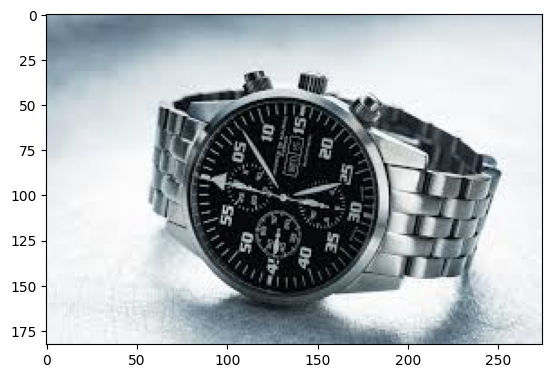

Loading pensandwatches/train/weights/best_int8_openvino_model for OpenVINO inference...
Using OpenVINO LATENCY mode for batch=1 inference...

Found https://raw.githubusercontent.com/chugmn/NYP107Assign/main/watchtest.jpeg locally at watchtest.jpeg
image 1/1 /content/watchtest.jpeg: 640x640 1 watch, 244.5ms
Speed: 10.5ms preprocess, 244.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
Loading pensandwatches/train/weights/best_int8_openvino_model for OpenVINO inference...
Using OpenVINO LATENCY mode for batch=1 inference...

Found https://raw.githubusercontent.com/chugmn/NYP107Assign/main/watchtest.jpeg locally at watchtest.jpeg
image 1/1 /content/watchtest.jpeg: 640x640 1 watch, 211.1ms
Speed: 8.2ms preprocess, 211.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'pen', 1: 'watch'}
obb: None
orig_img: ar

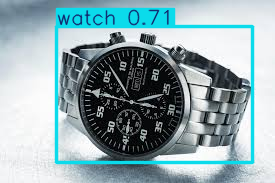

Image loaded successfully!


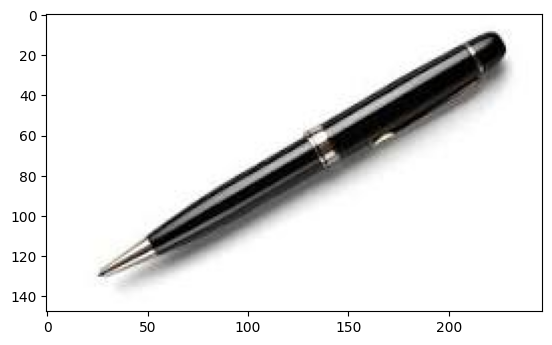

Loading pensandwatches/train/weights/best_int8_openvino_model for OpenVINO inference...
Using OpenVINO LATENCY mode for batch=1 inference...

Found https://raw.githubusercontent.com/chugmn/NYP107Assign/main/pentest.jpeg locally at pentest.jpeg
image 1/1 /content/pentest.jpeg: 640x640 1 pen, 201.3ms
Speed: 8.7ms preprocess, 201.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'pen', 1: 'watch'}
obb: None
orig_img: array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,

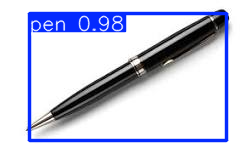

In [ ]:
#---
import requests
from PIL import Image
from io import BytesIO

# Image URL
url = 'https://raw.githubusercontent.com/chugmn/NYP107Assign/main/watchtest.jpeg'

# Fetch the image
response = requests.get(url)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    print("Image downloaded successfully!")
    # Open the image with PIL to check if it works
    img = Image.open(BytesIO(response.content))
    img.show()
else:
    print("Failed to download image. Status code:", response.status_code)


#---
import cv2
import requests
import numpy as np

# Path where the image is saved
image_path = '/content/watchtest.jpeg'

# Download the image
url = 'https://raw.githubusercontent.com/chugmn/NYP107Assign/main/watchtest.jpeg'
img_data = requests.get(url).content
with open(image_path, 'wb') as f:
    f.write(img_data)

# Read the image using OpenCV
img = cv2.imread(image_path)

if img is None:
    print("Image not read correctly!")
else:
    print("Image loaded successfully!")

# Show the image (optional)
import matplotlib.pyplot as plt
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

#

import ultralytics
from ultralytics import YOLO
from PIL import Image

#source = 'https://raw.githubusercontent.com/nyp-sit/iti107-2024S2/refs/heads/main/session-3/samples/sample_balloon.jpeg'
#source = './samples/sample_balloon.jpeg'
source = 'https://raw.githubusercontent.com/chugmn/NYP107Assign/main/watchtest.jpeg'
model = YOLO("pensandwatches/train/weights/best_int8_openvino_model", task='detect')
result = model(source, conf=0.5, iou=0.6)
model = YOLO("pensandwatches/train/weights/best_int8_openvino_model", task='detect')
result = model(source, conf=0.5, iou=0.6)
# Visualize the results
for i, r in enumerate(result):
    print(r)
    # Plot results image
    im_bgr = r.plot()  # BGR-order numpy array
    im_rgb = Image.fromarray(im_bgr[..., ::-1])  # RGB-order PIL image

    # Show results to screen (in supported environments)
    r.show()

    # Save results to disk
    r.save(filename=f"results{i}.jpg")




  # Pen detection


import cv2
import requests
import numpy as np

# Path where the image is saved
image_path = '/content/pentest.jpeg'

# Download the image
url = 'https://raw.githubusercontent.com/chugmn/NYP107Assign/main/pentest.jpeg'
img_data = requests.get(url).content
with open(image_path, 'wb') as f:
    f.write(img_data)

# Read the image using OpenCV
img = cv2.imread(image_path)

if img is None:
    print("Image not read correctly!")
else:
    print("Image loaded successfully!")

# Show the image (optional)
import matplotlib.pyplot as plt
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

#

import ultralytics
from ultralytics import YOLO
from PIL import Image

#source = 'https://raw.githubusercontent.com/nyp-sit/iti107-2024S2/refs/heads/main/session-3/samples/sample_balloon.jpeg'
#source = './samples/sample_balloon.jpeg'
source = 'https://raw.githubusercontent.com/chugmn/NYP107Assign/main/pentest.jpeg'
model = YOLO("pensandwatches/train/weights/best_int8_openvino_model", task='detect')
result = model(source, conf=0.5, iou=0.6)

# Visualize the results
for i, r in enumerate(result):
    print(r)
    # Plot results image
    im_bgr = r.plot()  # BGR-order numpy array
    im_rgb = Image.fromarray(im_bgr[..., ::-1])  # RGB-order PIL image

    # Show results to screen (in supported environments)
    r.show()

    # Save results to disk
    r.save(filename=f"results{i}.jpg")

## Download the Model

If you are training your model on Google Colab, you will download the exported OpenVINO model to a local PC. If you are training your model locally, then the exported model should already be on your local PC.

Run the following code to zip up the OpenVINO folder and download to local PC.

*Note: If you encountered error message "NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968", uncomment the following cell and run it.*


In [ ]:
# import locale
# locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
%%bash
mv ./pensandwatches/train/weights/best_int8_openvino_model/ .
zip -r best_int8_openvino_model.zip best_int8_openvino_model

# Now go to best_openvino_model to download the best_openvino_model.zip file

updating: best_int8_openvino_model/ (stored 0%)
updating: best_int8_openvino_model/best.xml (deflated 95%)
updating: best_int8_openvino_model/best.bin (deflated 18%)
updating: best_int8_openvino_model/metadata.yaml (deflated 32%)


mv: cannot move './pensandwatches/train/weights/best_int8_openvino_model/' to './best_int8_openvino_model': Directory not empty


## Streaming

We can also do real-time detection on a video or camera steram.

The code below uses openCV library to display video in a window, and can only be run locally on a local laptop.




### Video File

You need `OpenCV` to run the following code.  In your conda environment, install `opencv` for python using the following command:

```
pip3 install opencv-python
```
or
```
conda install opencv
```

Let's donwload the sample video file.

In [56]:
#!wget https://raw.githubusercontent.com/nyp-sit/iti107-2024S2/refs/heads/main/session-3/samples/pensandwatches.mp4
!wget https://githubusercontent.com/chugmn/NYP107Assign/raw/refs/heads/main/penwatch.mp4

--2024-12-26 07:01:57--  https://githubusercontent.com/chugmn/NYP107Assign/raw/refs/heads/main/penwatch.mp4
Resolving githubusercontent.com (githubusercontent.com)... failed: No address associated with hostname.
wget: unable to resolve host address ‘githubusercontent.com’


### Streaming and display video

In [50]:
'''
from ultralytics import YOLO
import cv2

# Load the YOLO model
model = YOLO("best_int8_openvino_model", task="detect")

# Open the video file
video_path = "penwatch1.mp4"
cap = cv2.VideoCapture(video_path)

# Loop through the video frames
while cap.isOpened():
    # Read a frame from the video
    success, frame = cap.read()

    if success:
        # Run YOLO inference on the frame on GPU Device 0
        results = model(frame, device="cpu")

        # Visualize the results on the frame
        annotated_frame = results[0].plot()

        # Display the annotated frame
        cv2.imshow("YOLO Inference", annotated_frame)

        # Break the loop if 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break
    else:
        # Break the loop if the end of the video is reached
        break

# Release the video capture object and close the display window
cap.release()
cv2.destroyAllWindows()
'''

### Detect and write to a video file

In [51]:
'''
from ultralytics import YOLO
import cv2
# from tqdm import tqdm
from tqdm.auto import tqdm

def write_video(video_in_filepath, video_out_filepath, model):
    # Open the video file

    video_reader = cv2.VideoCapture(video_in_filepath)

    nb_frames = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_h = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_w = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    fps = video_reader.get(cv2.CAP_PROP_FPS)

    video_writer = cv2.VideoWriter(video_out_filepath,
                            cv2.VideoWriter_fourcc(*'mp4v'),
                            fps,
                            (frame_w, frame_h))

    # Loop through the video frames
    for i in tqdm(range(nb_frames)):
        # Read a frame from the video
        success, frame = video_reader.read()

        if success:
            # Run YOLO inference on the frame on GPU Device 0
            results = model(frame, conf=0.9, device=0)

            # Visualize the results on the frame
            annotated_frame = results[0].plot()

            # Write the annotated frame
            video_writer.write(annotated_frame)

    video_reader.release()
    video_writer.release()
    cv2.destroyAllWindows()
    cv2.waitKey(1)
'''

In [52]:
'''
from pathlib import Path
import os

video_in_file = "penswatch.mp4"
basename = Path(video_in_file).stem
video_out_file = os.path.join(basename + '_detected' + '.mp4')
model = YOLO("best_int8_openvino_model", task="detect")
write_video(video_in_file, video_out_file, model)

'''

0it [00:00, ?it/s]

In [55]:
'''
from ultralytics import YOLO
import cv2
from tqdm.auto import tqdm
from pathlib import Path
import os

def write_video(video_in_filepath, video_out_filepath, model, conf=0.5, device="cpu"):
    # Open the video file
    video_reader = cv2.VideoCapture(video_in_filepath)

    if not video_reader.isOpened():
        print(f"Error: Unable to open input video file {video_in_filepath}")
        return

    nb_frames = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_h = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_w = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    fps = video_reader.get(cv2.CAP_PROP_FPS)

    # Initialize video writer
    video_writer = cv2.VideoWriter(
        video_out_filepath,
        cv2.VideoWriter_fourcc(*'mp4v'),  # Codec for MP4
        fps,
        (frame_w, frame_h)
    )

    # Loop through the video frames
    for _ in tqdm(range(nb_frames), desc="Processing video frames"):
        # Read a frame from the video
        success, frame = video_reader.read()

        if not success:
            break  # Break loop if end of video is reached

        # Run YOLO inference on the frame
        results = model(frame, conf=conf, device=device)

        # Visualize the results on the frame
        annotated_frame = results[0].plot()

        # Write the annotated frame to the output video
        video_writer.write(annotated_frame)

    # Release resources
    video_reader.release()
    video_writer.release()
    cv2.destroyAllWindows()

    print(f"Processed video saved to: {video_out_filepath}")

def display_video(video_filepath):
    """Display the processed video."""
    cap = cv2.VideoCapture(video_filepath)

    if not cap.isOpened():
        print(f"Error: Unable to open video file {video_filepath}")
        return

    while cap.isOpened():
        success, frame = cap.read()
        if not success:
            break
        cv2.imshow("Processed Video", frame)
        if cv2.waitKey(1) & 0xFF == ord("q"):  # Press 'q' to exit
            break

    cap.release()
    cv2.destroyAllWindows()

# Input and output video paths
video_in_file = "penwatch.mp4"
basename = Path(video_in_file).stem
video_out_file = os.path.join(basename + '_detected.mp4')

# Load the YOLO model
model = YOLO("best_int8_openvino_model", task="detect")

# Process the video
write_video(video_in_file, video_out_file, model, conf=0.5, device="cpu")

# Display the processed video
display_video(video_out_file)
'''

Processing video frames:   0%|          | 0/1906 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
Speed: 5.5ms preprocess, 270.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 285.3ms
Speed: 7.4ms preprocess, 285.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 290.9ms
Speed: 5.6ms preprocess, 290.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 271.1ms
Speed: 5.4ms preprocess, 271.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 289.8ms
Speed: 6.2ms preprocess, 289.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 281.2ms
Speed: 5.9ms preprocess, 281.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 266.5ms
Speed: 5.5ms preprocess, 266.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 283.9ms
Spee

DisabledFunctionError: cv2.imshow() is disabled in Colab, because it causes Jupyter sessions
to crash; see https://github.com/jupyter/notebook/issues/3935.
As a substitution, consider using
  from google.colab.patches import cv2_imshow


In [58]:
from ultralytics import YOLO
import cv2
from tqdm.auto import tqdm
from pathlib import Path
import os
from google.colab.patches import cv2_imshow
from google.colab import files

def write_video(video_in_filepath, video_out_filepath, model, conf=0.5, device="cpu"):
    # Open the video file
    video_reader = cv2.VideoCapture(video_in_filepath)

    if not video_reader.isOpened():
        print(f"Error: Unable to open input video file {video_in_filepath}")
        return

    nb_frames = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_h = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_w = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    fps = video_reader.get(cv2.CAP_PROP_FPS)

    # Initialize video writer
    video_writer = cv2.VideoWriter(
        video_out_filepath,
        cv2.VideoWriter_fourcc(*'mp4v'),  # Codec for MP4
        fps,
        (frame_w, frame_h)
    )

    # Loop through the video frames
    for _ in tqdm(range(nb_frames), desc="Processing video frames"):
        # Read a frame from the video
        success, frame = video_reader.read()

        if not success:
            break  # Break loop if end of video is reached

        # Run YOLO inference on the frame
        results = model(frame, conf=conf, device=device)

        # Visualize the results on the frame
        annotated_frame = results[0].plot()

        # Write the annotated frame to the output video
        video_writer.write(annotated_frame)

    # Release resources
    video_reader.release()
    video_writer.release()
    cv2.destroyAllWindows()

    print(f"Processed video saved to: {video_out_filepath}")

def display_video(video_filepath):
    """Display the processed video in Colab."""
    cap = cv2.VideoCapture(video_filepath)

    if not cap.isOpened():
        print(f"Error: Unable to open video file {video_filepath}")
        return

    while cap.isOpened():
        success, frame = cap.read()
        if not success:
            break
        cv2_imshow(frame)  # Use cv2_imshow to display frames in Colab
        # Add a break condition to avoid flooding Colab with too many frames
        key = cv2.waitKey(1)
        if key == ord("q"):  # Simulate pressing 'q' to quit
            break

    cap.release()
    print("Video display completed.")

# Input and output video paths
video_in_file = "penwatch.mp4"
basename = Path(video_in_file).stem
video_out_file = os.path.join(basename + '_detected.mp4')

# Load the YOLO model
model = YOLO("best_int8_openvino_model", task="detect")

# Process the video
write_video(video_in_file, video_out_file, model, conf=0.5, device="cpu")

# Display the processed video
display_video(video_out_file)

# Optionally, download the processed video
files.download(video_out_file)


Processing video frames:   0%|          | 0/1906 [00:00<?, ?it/s]

Loading best_int8_openvino_model for OpenVINO inference...
Using OpenVINO LATENCY mode for batch=1 inference...

0: 640x640 1 pen, 2 watchs, 284.1ms
Speed: 6.1ms preprocess, 284.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 pen, 3 watchs, 287.7ms
Speed: 6.0ms preprocess, 287.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 pen, 2 watchs, 267.5ms
Speed: 15.3ms preprocess, 267.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 pen, 2 watchs, 283.8ms
Speed: 8.2ms preprocess, 283.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 pen, 3 watchs, 286.5ms
Speed: 5.2ms preprocess, 286.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 pen, 3 watchs, 285.1ms
Speed: 7.6ms preprocess, 285.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 pen, 4 watchs, 291.7ms
Speed: 6.4ms preprocess, 291.7ms inferen

KeyboardInterrupt: 